# Zillow - Time series forecasting Model

## Business Case and Project focus
We will be presenting this case to a real estate investment firm from Philadelphia, that is looking for us to analyze the data and determine what Metro area is best for their investment and this analysis will give them the ability to narrow down their focus and determine where to look for investments.

We will be using the Zillow dataset which covers the years from 2000-2018 and we will be focused in the Northeast, our client has determined that the area of business for them is the states within a reasonable drive from their home office in Princeton, NJ.  We will filter the dataset to only contain the east coast homes from Delaware, Pennsylvania and New Jersey.  This will give them information on what the forecasted growth for these markets would be and where they should focus their attention and their greatest opportunities will be.

Our client also only wants to start with an investment of $250,000 per home since they will be looking for multiple homes to invest in, so we will have to filter the data set to eliminate the more expensive homes.


## Data set Utilized
The data set encompusess the sales data for over 

There are 14,723 rows and 272 variables:

* RegionID: Unique index, 58196 through 753844
* RegionName: Unique Zip Code, 1001 through 99901
* City: City in which the zip code is located
* State: State in which the zip code is located
* Metro: Metropolitan Area in which the zip code is located
* CountyName: County in which the zip code is located
* SizeRank: Numerical rank of size of zip code, ranked 1 through 14723 1996-04 through 2018-04: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code


# Exploratory Data Analysis and Data Preparation
###Importing necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import itertools
import pmdarima as pm
from pmdarima.arima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize']=[12,10]
sns.set_style(style = 'whitegrid')

## Importing Data and Preprocessing
Importing data and looking and Basic Info

In [2]:
df = pd.read_csv('/Users/jasonhart/Desktop/flatiron/phase_4/dsc-phase-4-choosing-a-dataset/time-series/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

The raw data set has 272 columns, because of the fact that the time data is in the columns and has 14,723 entries in the rows.  There are 7 columns which are focused on the location of the entry, but RegionID seems to be random, since in the head we can see two entries with Cook county Chicago and they have different RegionID's.  We will explore if this information means anything or not.

In [5]:
df['RegionID'].value_counts()

84654    1
60802    1
58299    1
63186    1
77596    1
        ..
67309    1
72802    1
74730    1
72705    1
95851    1
Name: RegionID, Length: 14723, dtype: int64

It appears that each entry has a separate RegionID and that they do not have any significance

## Filtering the Data to Tristate area and within our clients budget

We will filter the dataset to only include the 3 states with which we are concerned and then filter for our clients budget

In [6]:
#Using isin to filter
df_tri = df[df['State'].isin(['PA', 'DE', 'NJ'])]

In [7]:
#Checking to ensure Dataset only contains our 3 states
df_tri['State'].nunique()

3

In [8]:
#Dataset containing only the areas with a mean value under $250,000
df_tri_budget = df_tri[df_tri['2018-04'] <= 250000]

In [9]:
df_tri_budget['2018-04'].sort_values(ascending=False)

12452    249500
1999     249000
7736     248900
9345     248800
11075    248600
          ...  
6745      38500
10542     36600
14225     31400
6325      30400
7402      29000
Name: 2018-04, Length: 843, dtype: int64

Data if now filtered by state and for homes in our clients budget

## Melt Data Function

In [10]:
# Data Melted to turn the dates into the index

df_tri_melted = pd.melt(df_tri_budget, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'RegionID','SizeRank'], var_name='time')


In [11]:
df_tri_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223395 entries, 0 to 223394
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionName  223395 non-null  int64  
 1   City        223395 non-null  object 
 2   State       223395 non-null  object 
 3   Metro       219420 non-null  object 
 4   CountyName  223395 non-null  object 
 5   RegionID    223395 non-null  int64  
 6   SizeRank    223395 non-null  int64  
 7   time        223395 non-null  object 
 8   value       216642 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 15.3+ MB


In [12]:
df_tri_melted['time'] = pd.to_datetime(df_tri_melted['time'], infer_datetime_format=True)

In [13]:
df_tri_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223395 entries, 0 to 223394
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   RegionName  223395 non-null  int64         
 1   City        223395 non-null  object        
 2   State       223395 non-null  object        
 3   Metro       219420 non-null  object        
 4   CountyName  223395 non-null  object        
 5   RegionID    223395 non-null  int64         
 6   SizeRank    223395 non-null  int64         
 7   time        223395 non-null  datetime64[ns]
 8   value       216642 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 15.3+ MB


In [14]:
#df_tri_melted.set_index('time', inplace=True)

In [15]:
df_tri_melted.tail()

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
223390,16836,Girard,PA,DuBois,Clearfield,64760,14622,2018-04-01,58300.0
223391,8317,Weymouth,NJ,Atlantic City,Atlantic,61044,14633,2018-04-01,165000.0
223392,8241,Port Republic,NJ,Atlantic City,Atlantic,61023,14648,2018-04-01,179300.0
223393,17006,Toboyne,PA,Harrisburg,Perry,64839,14653,2018-04-01,70800.0
223394,15083,Sutersville,PA,Pittsburgh,Westmoreland,63889,14666,2018-04-01,82600.0


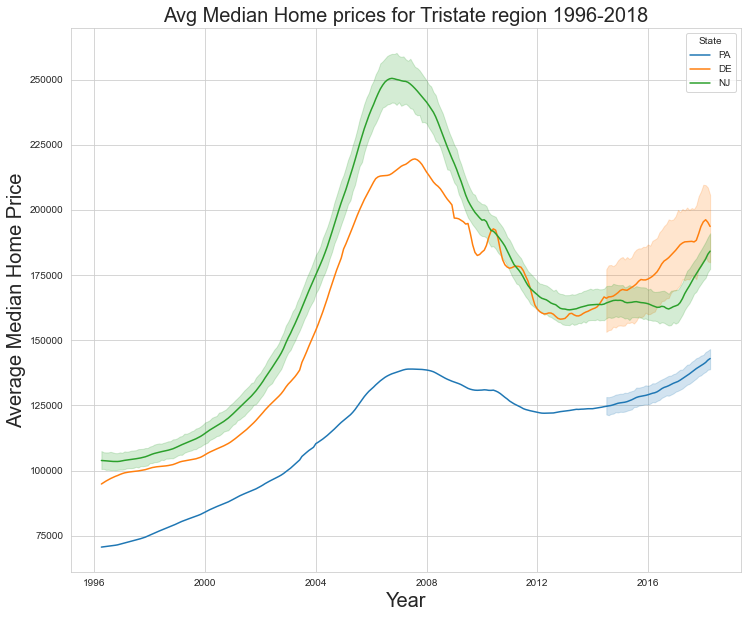

In [16]:
sns.lineplot(data= df_tri_melted, x= 'time',y = 'value', hue = 'State')
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Average Median Home Price', fontsize = 20)
plt.title('Avg Median Home prices for Tristate region 1996-2018', fontsize = 20);

All three states have a similar shape to their histories, PA appears to have the lowest risk factor, as the curve is smoother and flatter then the other two.  Delaware appears to have the highest volatility with smaller peaks and valleys in its path and NJ seems to be the greatest risk reward state, having the highest peak, but also the steepest climb and descent.

As we can see from this graph, there was a market crash in 2008, being that the real estate market is a historically stable market and this appears to be a blip on the radar, we will focus on the data from 2012 till 2018.  This is after the market began to rebound.

Since we will be looking at the different Metro areas in our filtered dataset we need to split the dataset onto the metro areas and then set the index equal to the time series for modeling

In [17]:
df_metro = df_tri_melted.pivot_table(values='value', index='time', columns='Metro', aggfunc='mean')


In [18]:
df_metro_filtered = df_metro['2012-01-01':]

In [19]:
df_metro_filtered.head()

Metro,Allentown,Altoona,Atlantic City,Bloomsburg,Bradford,Chambersburg,Dover,DuBois,East Stroudsburg,Erie,...,Sayre,Scranton,Somerset,State College,Sunbury,Trenton,Vineland,Williamsport,York,Youngstown
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01,158960.526316,113300.000000,178769.230769,116533.333333,54400.000000,149014.285714,161990.0,53638.461538,140015.0,114816.666667,...,112628.571429,101541.463415,86200.000000,158233.333333,109575.0,149442.857143,141325.0,124612.5,156944.117647,87028.571429
2012-02-01,158223.684211,112588.888889,177169.230769,116416.666667,55016.666667,148957.142857,162100.0,53738.461538,139165.0,114900.000000,...,113000.000000,101602.439024,86381.818182,158750.000000,109850.0,147828.571429,142975.0,124975.0,155923.529412,87142.857143
2012-03-01,157800.000000,112366.666667,176146.153846,116616.666667,55433.333333,149428.571429,162240.0,53869.230769,138240.0,115016.666667,...,112885.714286,101514.634146,86390.909091,159083.333333,109962.5,146128.571429,142850.0,125137.5,155023.529412,87092.857143
2012-04-01,157610.526316,112633.333333,176407.692308,116666.666667,55816.666667,148642.857143,162260.0,53953.846154,137105.0,115155.555556,...,112271.428571,101414.634146,86409.090909,159316.666667,110112.5,144628.571429,141500.0,125475.0,154647.058824,86907.142857
2012-05-01,157036.842105,113500.000000,177253.846154,116750.000000,56400.000000,146157.142857,162370.0,53892.307692,136630.0,115355.555556,...,112128.571429,101351.219512,86472.727273,159833.333333,110137.5,143771.428571,140125.0,125837.5,154370.588235,87164.285714


In [20]:
df_metro_filtered.isna().sum().sum()

0

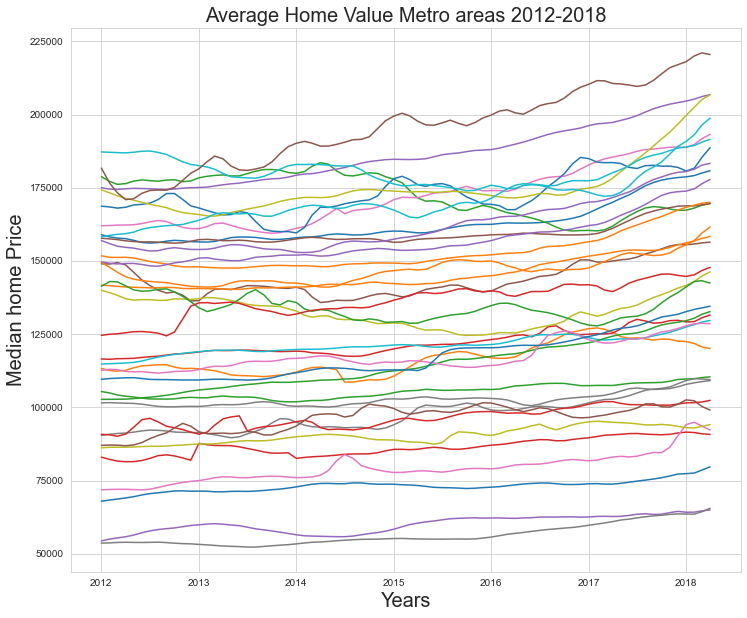

In [21]:
plt.plot(df_metro_filtered)
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Median home Price', fontsize = 20)
plt.title('Average Home Value Metro areas 2012-2018', fontsize = 20);

The data has been successfully filtered to only contain the data following 2012, the retail market is generally a stable investment and environment, so we will focus on the data following the crash

## Train Validation split
Here we will need to split the time series data into a Training set and a Testing set

In [22]:
#Determining where the cutoff value is for Split
cutoff = round(df_metro_filtered.shape[0]* 0.8)
cutoff

61

In [23]:
train = df_metro_filtered[:61]
valid = df_metro_filtered[61:]

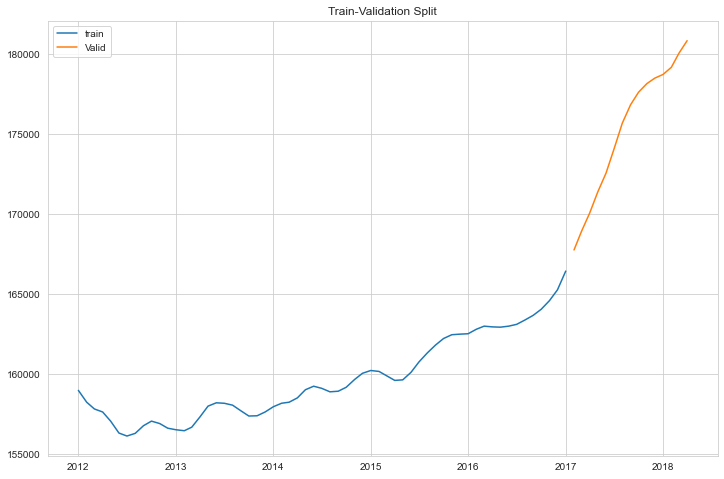

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train['Allentown'], label = 'train')
ax.plot(valid['Allentown'], label = 'Valid')
ax.set_title('Train-Validation Split');
plt.legend();

Our Dataset has been split into a Train and a validation set

In [25]:
train.tail()

Metro,Allentown,Altoona,Atlantic City,Bloomsburg,Bradford,Chambersburg,Dover,DuBois,East Stroudsburg,Erie,...,Sayre,Scranton,Somerset,State College,Sunbury,Trenton,Vineland,Williamsport,York,Youngstown
time,,,,,,,,,,,,,,,,,,,,,
2016-09-01,163650.000000,123350.0,161553.846154,127833.333333,62550.000000,145457.142857,178763.636364,58530.769231,128450.0,124811.111111,...,125457.142857,102551.219512,92345.454545,175800.000000,121812.5,146957.142857,131625.0,140850.0,167682.352941,98635.714286
2016-10-01,164028.947368,124780.0,160553.846154,126266.666667,62600.000000,146814.285714,178918.181818,58776.923077,129445.0,124966.666667,...,126114.285714,102941.463415,93136.363636,176766.666667,122312.5,146857.142857,130800.0,142010.0,167938.235294,97557.142857
2016-11-01,164568.421053,125680.0,160238.461538,125250.000000,62616.666667,148842.857143,179872.727273,59000.000000,131420.0,124933.333333,...,125585.714286,103217.073171,94081.818182,177400.000000,122900.0,147114.285714,129875.0,142080.0,168714.705882,96621.428571
2016-12-01,165244.736842,126260.0,160369.230769,124833.333333,62516.666667,150357.142857,181354.545455,59315.384615,132580.0,124466.666667,...,124385.714286,103458.536585,94627.272727,177416.666667,123575.0,147142.857143,128825.0,141810.0,169579.411765,96428.571429
2017-01-01,166415.789474,126880.0,160430.769231,124983.333333,62566.666667,150342.857143,182763.636364,59746.153846,131935.0,123827.777778,...,123114.285714,103643.902439,95045.454545,177383.333333,124212.5,147600.000000,128100.0,141880.0,170070.588235,96557.142857


## Exploratory data analysis without modeling
We will attempt to use straight ROI on the data to see if the modeling is a better forecast, we will compare modeling to the straight mathematical process.

In [26]:
names = []
ROI = []
#Itterating through dataset to determine what the raw ROI is for each Metro
for i in range(len(train.columns)):
    
    metro_name = train.columns[i][:]
    initial_value = train[train.columns[i]]['2012-01-01']
    latest_value = train[train.columns[i]]['2017-01-01']
    
    calculate_roi = round(((latest_value-initial_value)/initial_value)*100, 2)
    
    names.append(metro_name)
    ROI.append(calculate_roi)
    
df_roi_train = pd.DataFrame()
df_roi_train['Metro'] = names
df_roi_train['ROI'] = ROI

In [27]:
df_roi_train.sort_values(['ROI'], ascending=False, inplace=True)

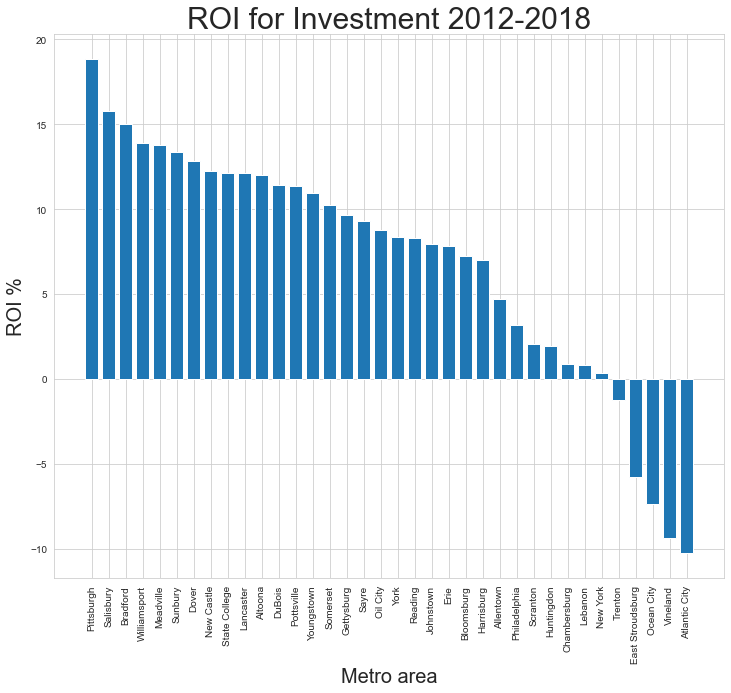

In [28]:
plt.bar(df_roi_train['Metro'], df_roi_train['ROI'])
plt.xticks(rotation=90)
plt.xlabel('Metro area', fontsize=20)
plt.ylabel('ROI %', fontsize = 20)
plt.title('ROI for Investment 2012-2018', fontsize = 30);

In [29]:
df_roi_train.head()

,Metro,ROI
22,Pittsburgh,18.84
25,Salisbury,15.76
4,Bradford,15.01
33,Williamsport,13.86
16,Meadville,13.78


As we can see above, a cursory ROI calculation would lead us to the 5 metro areas listed as the top choices for investment.  We will check to see if this holds true once we have run modeling on the dataset

In [30]:
naive = train.shift(1)
naive.head()

Metro,Allentown,Altoona,Atlantic City,Bloomsburg,Bradford,Chambersburg,Dover,DuBois,East Stroudsburg,Erie,...,Sayre,Scranton,Somerset,State College,Sunbury,Trenton,Vineland,Williamsport,York,Youngstown
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,158960.526316,113300.000000,178769.230769,116533.333333,54400.000000,149014.285714,161990.0,53638.461538,140015.0,114816.666667,...,112628.571429,101541.463415,86200.000000,158233.333333,109575.0,149442.857143,141325.0,124612.5,156944.117647,87028.571429
2012-03-01,158223.684211,112588.888889,177169.230769,116416.666667,55016.666667,148957.142857,162100.0,53738.461538,139165.0,114900.000000,...,113000.000000,101602.439024,86381.818182,158750.000000,109850.0,147828.571429,142975.0,124975.0,155923.529412,87142.857143
2012-04-01,157800.000000,112366.666667,176146.153846,116616.666667,55433.333333,149428.571429,162240.0,53869.230769,138240.0,115016.666667,...,112885.714286,101514.634146,86390.909091,159083.333333,109962.5,146128.571429,142850.0,125137.5,155023.529412,87092.857143
2012-05-01,157610.526316,112633.333333,176407.692308,116666.666667,55816.666667,148642.857143,162260.0,53953.846154,137105.0,115155.555556,...,112271.428571,101414.634146,86409.090909,159316.666667,110112.5,144628.571429,141500.0,125475.0,154647.058824,86907.142857


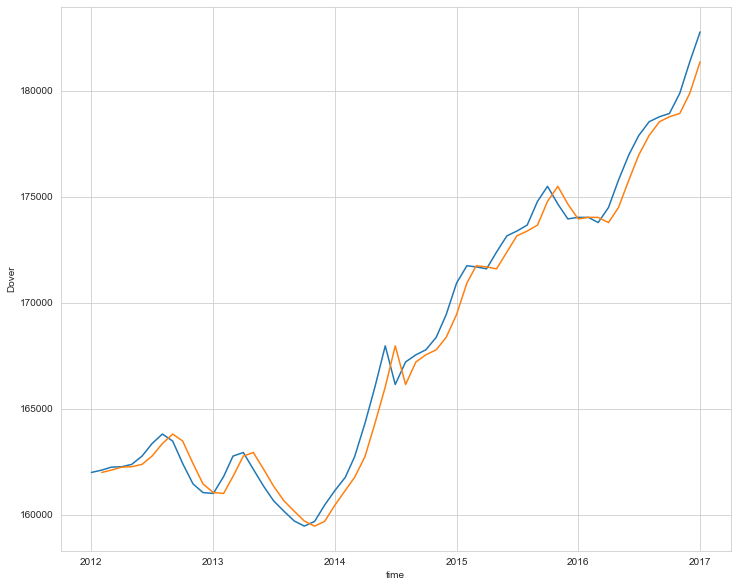

In [31]:
sns.lineplot(data = train, x= train.index,y = 'Dover')
sns.lineplot(data = naive, x =naive.index, y='Dover');

In [32]:
round(train.diff(), 2)

Metro,Allentown,Altoona,Atlantic City,Bloomsburg,Bradford,Chambersburg,Dover,DuBois,East Stroudsburg,Erie,...,Sayre,Scranton,Somerset,State College,Sunbury,Trenton,Vineland,Williamsport,York,Youngstown
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,-736.84,-711.11,-1600.00,-116.67,616.67,-57.14,110.00,100.00,-850.0,83.33,...,371.43,60.98,181.82,516.67,275.0,-1614.29,1650.0,362.5,-1020.59,114.29
2012-03-01,-423.68,-222.22,-1023.08,200.00,416.67,471.43,140.00,130.77,-925.0,116.67,...,-114.29,-87.80,9.09,333.33,112.5,-1700.00,-125.0,162.5,-900.00,-50.00
2012-04-01,-189.47,266.67,261.54,50.00,383.33,-785.71,20.00,84.62,-1135.0,138.89,...,-614.29,-100.00,18.18,233.33,150.0,-1500.00,-1350.0,337.5,-376.47,-185.71
2012-05-01,-573.68,866.67,846.15,83.33,583.33,-2485.71,110.00,-61.54,-475.0,200.00,...,-142.86,-63.41,63.64,516.67,25.0,-857.14,-1375.0,362.5,-276.47,257.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-01,292.11,1320.00,-1315.38,333.33,0.00,485.71,236.36,223.08,565.0,5.56,...,928.57,663.41,-754.55,166.67,450.0,-300.00,-700.0,1200.0,120.59,-914.29
2016-10-01,378.95,1430.00,-1000.00,-1566.67,50.00,1357.14,154.55,246.15,995.0,155.56,...,657.14,390.24,790.91,966.67,500.0,-100.00,-825.0,1160.0,255.88,-1078.57
2016-11-01,539.47,900.00,-315.38,-1016.67,16.67,2028.57,954.55,223.08,1975.0,-33.33,...,-528.57,275.61,945.45,633.33,587.5,257.14,-925.0,70.0,776.47,-935.71


# Modeling
Pittsburgh showed the highest ROI in the cursory investigation, so we will use Pittsburgh to train our model

In [33]:
#Filtering out results for Pittsburgh to train the model
pittsburgh = df_metro_filtered[['Pittsburgh']].copy()

In [34]:
pittsburgh = pittsburgh.loc['2012-01-01':]

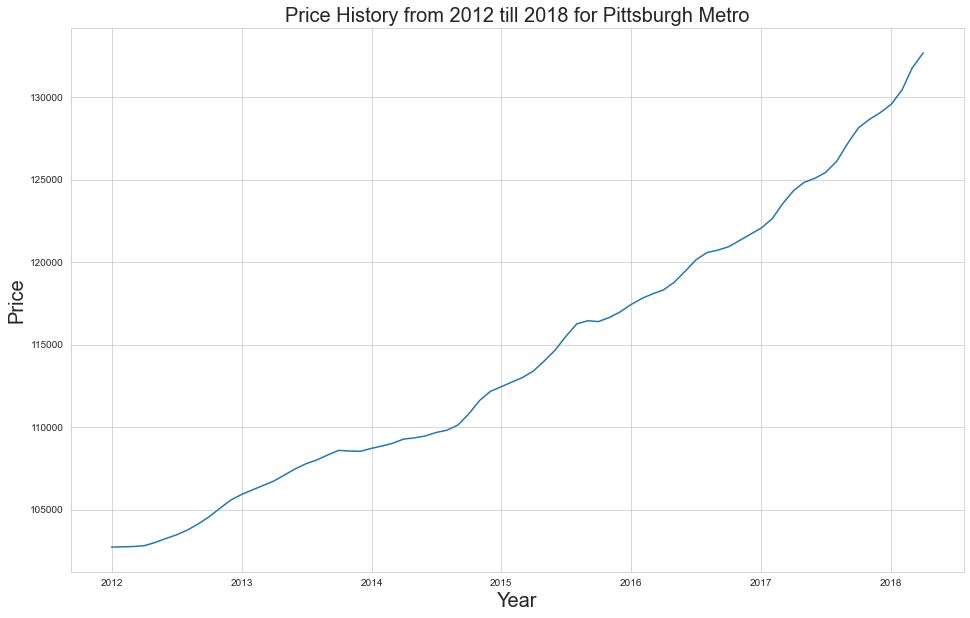

In [35]:
plt.subplots(figsize=(16,10))
plt.plot(pittsburgh)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Price History from 2012 till 2018 for Pittsburgh Metro', fontsize = 20);

As we can see, there is a fairly steady incline in price for Pittsburgh and it should give us a pretty good option for modeling

## Train Test Split

We will split our data for the modeling process using the last 24 months as our test data

In [36]:
pittsburgh_train = pittsburgh[:'2016-04-01']
pittsburgh_test = pittsburgh['2016-05-01':]

## Auto-ARIMA method
Utilizing auto-ARIMA method to find optimal values for p,d and q, so that we can model and forecast in the most efficient manner

In [37]:
auto_model = pm.auto_arima(pittsburgh_train,
                     start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1356.611, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1323.210, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1317.653, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=692.840, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1317.821, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=674.431, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  A

In [38]:
#Determining best model order from auto ARIMA
auto_model.order

(2, 0, 1)

In [39]:
#Determining if there is any seasonality that needs to be accounted for
auto_model.seasonal_order

(0, 0, 0, 0)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1390      0.127      8.949      0.000       0.890       1.388
ar.L2         -0.1365      0.128     -1.068      0.285      -0.387       0.114
ma.L1          0.9661      0.094     10.245      0.000       0.781       1.151
sigma2      1.605e+04   3312.619      4.845      0.000    9558.490    2.25e+04


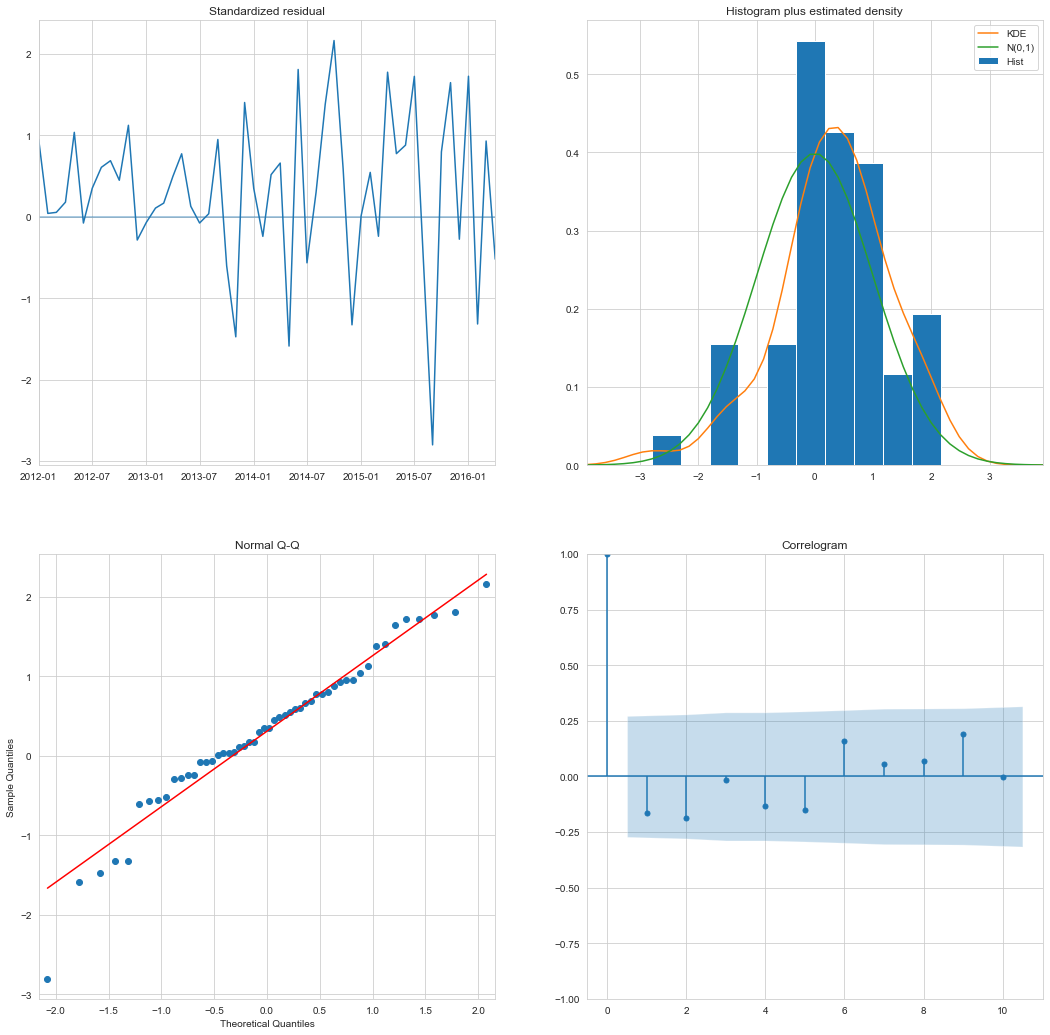

In [40]:
#Model using results of auto_ARIMA
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(pittsburgh_train, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model
output = ARIMA_MODEL.fit()
#Print the results and plot the results
print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

There are some outliers and there is some noise at both ends of the spectrum for Ocean City, but it appears we meet all requirements and that the first two lags are correlated above the required .05 percent level for correlations.  The rest will not provide a good model.
    
* In the top right our KDE line closely follows the normal distribution, having a mean of 0 and a std   deviation of 1
* Our qq plot closely follows our our residuals line trend line.  This shows us that our residuals are normally distributed
* From the Correlogram we can see that the time series residuals have a low correlation with their lag versions and it becomes clearer as we move further along the time series

From these observations, we can assume that there are not obvious correlations and we can fit the model for predictions of future prices

## Model Effectiveness
we will run the model and calculate the lower and upper range to determine how risky our model is and what the range will be for predictions

In [41]:
# Running predictions and placing upper and lower predictions in a dataframe to calculate risk

pred = output.get_prediction(start=('2016-05-01'), end=('2018-04-01'), dynamic=False)
pred_range = pred.conf_int()
pred_range


,lower Pittsburgh,upper Pittsburgh
2016-05-01,118300.978639,118798.110802
2016-06-01,118296.692531,119454.369472
2016-07-01,118410.533156,120023.366425
2016-08-01,118574.861271,120547.793674
2016-09-01,118767.417304,121046.521005
2016-10-01,118978.486583,121528.806797
2016-11-01,119202.975684,121999.687380
2016-12-01,119437.846987,122462.197614
2017-01-01,119681.120710,122918.321930
2017-02-01,119931.422636,123369.440214


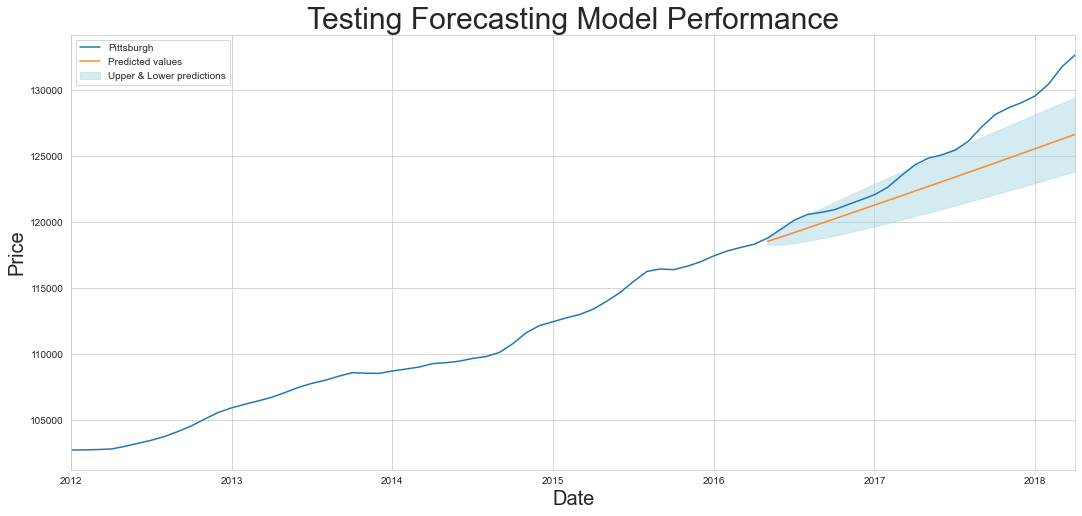

In [42]:
rcParams['figure.figsize'] = 18, 8

ax = pittsburgh.plot(label='recorded')

pred.predicted_mean.plot(ax=ax, label='Predicted values', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_range.index,
                pred_range.iloc[:, 0],
                pred_range.iloc[:, 1], color='lightblue', alpha=0.5,label = 'Upper & Lower predictions')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend();

Model predictions appear to under valuate the future sale price, but this will also help mitigate the risk of investment

## Forecasting the future

In [43]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(pittsburgh,
                                       order=(2, 0,1),
                                       seasonal_order=(0,0,0,0),
                                       enforce_invertibility=False,
                                       enforce_stationarity=False)

full_output = ARIMA_MODEL.fit()

print(full_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2063      0.093     12.958      0.000       1.024       1.389
ar.L2         -0.2033      0.094     -2.174      0.030      -0.387      -0.020
ma.L1          0.8229      0.098      8.372      0.000       0.630       1.016
sigma2      2.234e+04   3665.804      6.093      0.000    1.52e+04    2.95e+04


In [44]:
forecast = full_output.get_forecast(24)
predic = forecast.conf_int()
predic['value'] = forecast.predicted_mean
predic.columns = ['lower', 'upper', 'prediction']
predic

,lower,upper,prediction
2018-05-01,132881.898016,133467.760111,133174.829063
2018-06-01,133000.482662,134325.818853,133663.150758
2018-07-01,133222.678590,135089.627559,134156.153075
2018-08-01,133501.237804,135801.880656,134651.559230
2018-09-01,133814.063533,136483.763259,135148.913396
2018-10-01,134149.966116,137146.291147,135648.128631
2018-11-01,134502.765712,137795.619774,136149.192743
2018-12-01,134868.732065,138435.485328,136652.108697
2019-01-01,135245.436833,139068.328269,137156.882551
2019-02-01,135631.201964,139695.840056,137663.521010


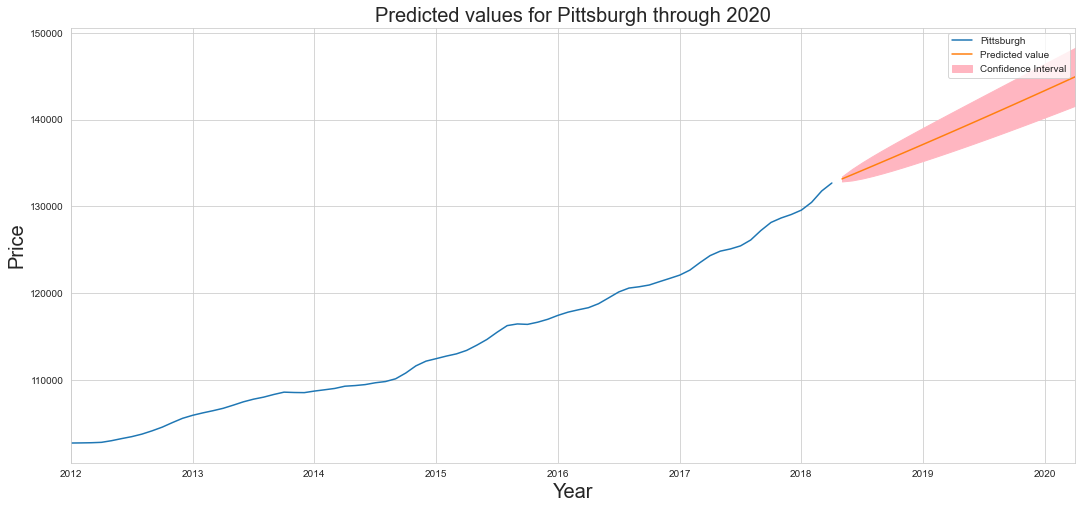

In [45]:
fig, ax = plt.subplots()
pittsburgh.plot(ax=ax,label="True value")
predic['prediction'].plot(ax=ax, label = "Predicted value")
ax.fill_between(x = predic.index, y1 = predic['lower'], y2= predic['upper'],
                color = 'lightpink', label = 'Confidence Interval' )

ax.legend()
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.title('Predicted values for Pittsburgh through 2020', fontsize = 20);

Now that we have our model and predictions for Pittsburgh, we will iterate the model over all of our Metro areas and forecast the average home for all Metro areas in our dataset

## Forecasting Model across all Metro in dataset

In [46]:
metro_predic = {}
metro_name = []
lower_val = []
upper_val = []
predic_val = []
for metro in df_metro_filtered:
    
    
    #Filtering data to only include data after 2012
    recent_series = df_metro_filtered[metro]['2012':]
    
    # Splitting data into train and test.
    train_series = recent_series[:'2017-04']
    test_series = recent_series['2017-05':]
    
    #Auto ARIMA model
    auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)   
    #Values from Auto Arima plugde into SARIMAX model    
    SARIMAX_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = SARIMAX_MODEL.fit()

    ## Getting a forecast for the next 36 months after the last absrecorded date on our dataset.
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','mean'] 
    metro_name.append(metro) 
    
    forecast = prediction['mean'][35]
    low_int =  prediction['lower'][35]
    high_int = prediction['upper'][35]
    #Appending values to create a dataframe of predicted results
   
    predic_val.append(forecast)
    lower_val.append(low_int)
    upper_val.append(high_int)
    df_metro_predic = pd.DataFrame(index=metro_name)
    df_metro_predic['Upper'] = upper_val
    df_metro_predic['Lower'] = lower_val
    df_metro_predic['Prediction'] = predic_val


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1717.542, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1675.035, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=919.326, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=878.549, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1667.216, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1665.752, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 0.728 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1675.753, Time=0.01 sec
 ARIMA(1,0,

 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1040.431, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1673.893, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1042.770, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1213.781, Time=0.10 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 0.603 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1581.085, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=824.317, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=783.774, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1530.714, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=780.729, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1530

 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.873 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1715.615, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1673.013, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=876.522, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=868.864, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.386, Time=0.16 sec
 ARI

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1658.021, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=845.235, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1657.604, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=855.177, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 0.844 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1671.829, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1629.744, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1622.256, Time=0.

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=955.482, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1593.326, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=961.612, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=954.049, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1592.784, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=960.090, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1593.991, Time=0.03 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=949.322, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=950.501, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=951.356, Time=0.10 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=951.196, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : 

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=985.058, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1007.447, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=986.894, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=986.847, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=998.170, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=988.695, Time=0.11 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.129 seconds


In [47]:
df_metro_predic.head()

,Upper,Lower,Prediction
Allentown,205884.746158,182243.092753,194063.919455
Altoona,142089.614407,103059.180543,122574.397475
Atlantic City,188860.700017,145061.249198,166960.974607
Bloomsburg,153693.626880,125147.357552,139420.492216
Bradford,78912.381739,59787.771573,69350.076656


In [48]:
df_current_value = df_metro_filtered.T

In [49]:
df_current_value['Staring Value'] = df_current_value[['2018-04-01']]

In [50]:
df_metro_predic['Starting Value'] = df_current_value['Staring Value']

In [51]:
df_metro_predic = round(df_metro_predic, 2)
df_metro_predic.head()

,Upper,Lower,Prediction,Starting Value
Allentown,205884.75,182243.09,194063.92,180813.16
Altoona,142089.61,103059.18,122574.40,120090.00
Atlantic City,188860.70,145061.25,166960.97,169607.69
Bloomsburg,153693.63,125147.36,139420.49,131550.00
Bradford,78912.38,59787.77,69350.08,64983.33


In [52]:
df_metro_predic['ROI'] = round((df_metro_predic['Prediction']-df_metro_predic['Starting Value'])/df_metro_predic['Starting Value'], 2)*100

In [53]:
df_metro_predic['Error Percentage']= round((df_metro_predic['Upper']-df_metro_predic['Lower'])/df_metro_predic['Starting Value'], 2)*100

In [54]:
df_metro_predic.sort_values(by ='ROI', ascending=False, inplace=True)

In [55]:
df_metro_predic.head()

,Upper,Lower,Prediction,Starting Value,ROI,Error Percentage
Ocean City,293927.48,186739.71,240333.60,198750.00,21.0,54.0
Oil City,104495.18,81397.48,92946.33,79680.00,17.0,29.0
Meadville,128164.13,82369.72,105266.93,92241.67,14.0,50.0
Reading,217988.59,189275.25,203631.92,177856.25,14.0,16.0
Pittsburgh,156099.54,145644.64,150872.09,132702.45,14.0,8.0


In [56]:
df_metro_predic.reset_index(inplace=True)
df_metro_predic.rename({'index':'Metro'}, axis=1, inplace=True)
df_metro_predic.head()

,Metro,Upper,Lower,Prediction,Starting Value,ROI,Error Percentage
0,Ocean City,293927.48,186739.71,240333.60,198750.00,21.0,54.0
1,Oil City,104495.18,81397.48,92946.33,79680.00,17.0,29.0
2,Meadville,128164.13,82369.72,105266.93,92241.67,14.0,50.0
3,Reading,217988.59,189275.25,203631.92,177856.25,14.0,16.0
4,Pittsburgh,156099.54,145644.64,150872.09,132702.45,14.0,8.0


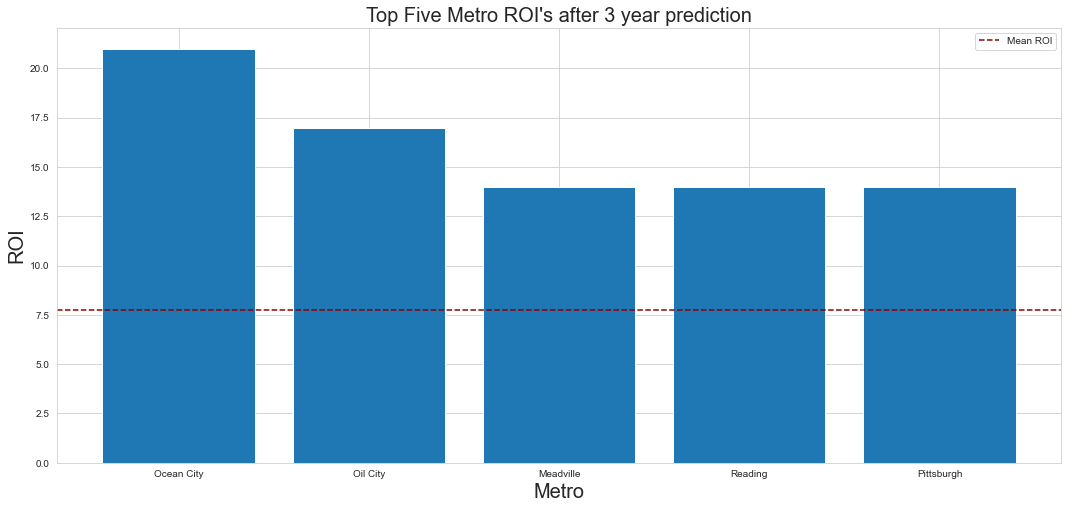

In [58]:
plt.bar(df_metro_predic['Metro'].head(), df_metro_predic['ROI'].head())
plt.axhline(y = df_metro_predic['ROI'].mean(), label = 'Mean ROI', color='darkred', linestyle ='--')
plt.xlabel('Metro', fontsize=20)
plt.ylabel('ROI', fontsize = 20)
plt.title("Top Five Metro ROI's after 3 year prediction", fontsize= 20)
plt.legend();

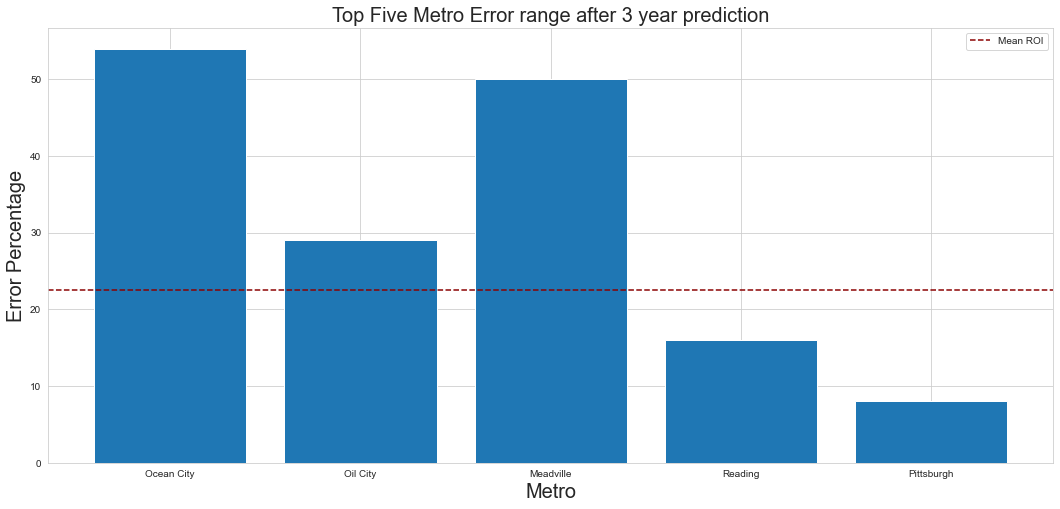

In [59]:
plt.bar(df_metro_predic['Metro'].head(), df_metro_predic['Error Percentage'].head())
plt.axhline(y = df_metro_predic['Error Percentage'].mean(), label = 'Mean ROI', color='darkred', linestyle='--')
plt.xlabel('Metro', fontsize=20)
plt.ylabel('Error Percentage', fontsize = 20)
plt.title("Top Five Metro Error range after 3 year prediction", fontsize= 20)
plt.legend();

In [ ]:
df_metro_predic.sort_values('Error Percentage')

# Conclusion and Recommendations

In [76]:
df_metro_predic

,Metro,Upper,Lower,Prediction,Starting Value,ROI,Error Percentage
0,Ocean City,293927.48,186739.71,240333.60,198750.00,21.0,54.0
1,Oil City,104495.18,81397.48,92946.33,79680.00,17.0,29.0
2,Meadville,128164.13,82369.72,105266.93,92241.67,14.0,50.0
3,Reading,217988.59,189275.25,203631.92,177856.25,14.0,16.0
4,Pittsburgh,156099.54,145644.64,150872.09,132702.45,14.0,8.0
5,DuBois,80641.02,67369.77,74005.40,65561.54,13.0,20.0
6,Salisbury,273513.78,219355.86,246434.82,220466.67,12.0,25.0
7,New York,249401.95,209093.37,229247.66,206733.33,11.0,19.0
8,Sunbury,161379.14,138305.66,149842.40,134550.00,11.0,17.0
9,State College,223844.55,197070.51,210457.53,191533.33,10.0,14.0


In [79]:
print(f'The Metro area with the highest ROI is {df_metro_predic.Metro[0]} with a forecast ROI of {df_metro_predic.ROI[0]}')
print(f'The Metro area with the second highest ROI is {df_metro_predic.Metro[1]} with a forecast ROI of {df_metro_predic.ROI[1]}')
print(f'The Metro area with the third highest ROI is {df_metro_predic.Metro[2]} with a forecast ROI of {round(df_metro_predic.ROI[2], 2)}')
print(f'The Metro area with the fourth highest ROI is {df_metro_predic.Metro[3]} with a forecast ROI of {round(df_metro_predic.ROI[3], 2)}')
print(f'The Metro area with the fifth highest ROI is {df_metro_predic.Metro[4]} with a forecast ROI of {round(df_metro_predic.ROI[4], 2)}')

The Metro area with the highest ROI is Ocean City with a forecast ROI of 21.0
The Metro area with the second highest ROI is Oil City with a forecast ROI of 17.0
The Metro area with the Highest ROI is Meadville with a forecast ROI of 14.0
The Metro area with the Highest ROI is Reading with a forecast ROI of 14.0
The Metro area with the Highest ROI is Pittsburgh with a forecast ROI of 14.0


Now if we take a look at the top five ROI Metro's in conjunction with the possible error, derived from the spread of the confidence interval.  We can see that the top three Metros all have an error percentage above the mean of all the Metros in our dataset.  This would cause concern and leads us to recommend Pittsburgh and Reading as our top two Metro areas for investment, since they couple a lower risk of prediction with an ROI still well above the mean ROI for the total set.